### Preparing the notebook

In [6]:
from utilities.helpers import check

check()

Tensorflow version 	= 1.7 [ok]
Keras version 		= 2.1 [ok]
OpenCV version 		= 3.3 [ok]

1 GPU detected


In [3]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
from utilities.helpers import Time

In [5]:
# # # Jupyter will automaticaly reload libraries if they have been modified
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

---

# Table of Contents
---
- **Data**
    - Loading and pre-processing the dataset
    - Visualizing the dataset
    
- **Training/Loading the model**
- **Evaluating the model**
- **Results**
    - Predictions
    - Generating the Class Activation Maps
- **Extending the dataset with images scraped from Google image**

# 1. Data
---

## Loading and pre-processing the dataset

The data used to train the classifier comes from the [INRIA person dataset](http://pascal.inrialpes.fr/data/human/).

This dataset contains images with and without persons.

Loading the data ...
- ... transforms images into a 4D tensor of shape `(samples_size, 224, 224, 3)` suitable for supplying to a Keras CNN
- ... transforms class labels into one hot encoded labels.
- ... creates a validation folder using 20% of the original training data (The INRIA person dataset originaly doesn't contain validation data)
- ... balances the data: originaly, there are 1669 negatives and 900 positives which means that the model could reach an accuracy of 70% by always predicting negatives. We therefore do not load the excess of negatives.

The training tensors and labels can be accessed as follows:
```
data.X_train
data.y_train
```
Same goes for the validation and testing data (`X_valid`, `y_test` etc.)

In [20]:
from utilities import datasets

data = datasets.InriaPersonDataset("INRIAPerson")

100%|██████████| 354/354 [00:04<00:00, 79.57it/s]


## Visualizing the dataset

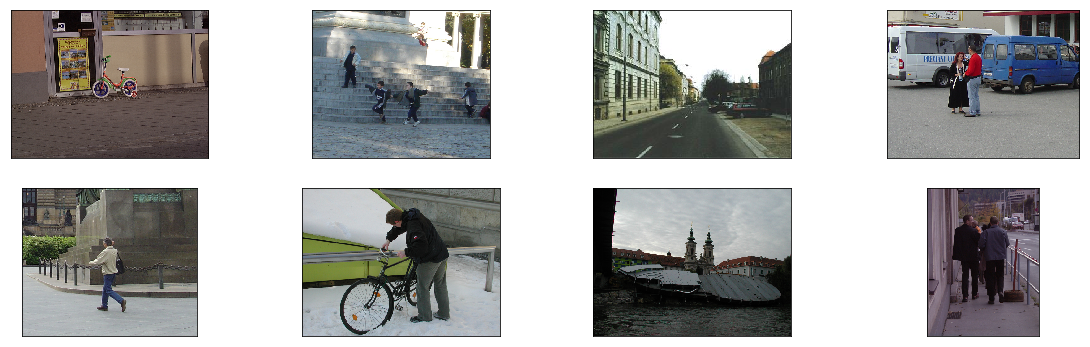

In [8]:
data.examples(sample="Test", number=8)

In [9]:
data.classes

['neg', 'pos']

In [10]:
data.statistics()

,neg,pos,Total
Classes,,,
Train,415,423,838
Valid,195,189,384
Test,226,288,514
,836,900,1736


# 2.  Training the model
---

### Model

In [7]:
from utilities.gapModels import MobileNetGAP

The `MobileNetGAP` class can be used just as any **compiled** Keras model (`keras.models`). 

This model is a the MobileNet model, top not included, that ends with a GlobalAveragePooling layer, followed by a dense layer with as many neurones as there are classes in the dataset.

The ConvNet layers of the model have been pretrained on the [ImageNet](http://image-net.org) dataset.

We will perform **transfert learning** by training the dense layer and retraining only the last two convnet layers (as the database is quite small).

Once trained it will be possible to load the model by simply calling:
```
model = MobileNetGAP(path='saved_model/mobilenet.h5')
```

Let's now create the compiled model:

In [12]:
model = MobileNetGAP(nb_classes=len(data.classes))

### Classifier

In [8]:
from utilities.classifier import Classifier

To train the model and save it, we will create an instance of the `Classifier` class.


A classifier takes as parameter a model, preferably built with a subclass of `AbstractModelGAP` (see `./utilities/gapModels.py`) as this will make the generation of CAMs easier.

Classifiers can be fitted to a dataset (which will train the model given as parameter).

Once fitted, they can be used to predict the class of an image or to generate **Class Activation Maps** (CAM)

Classifiers can also be used with a pretrained model loaded with `MobileNetGAP(path)`. They then can, but don't need to be fitted again to generate predictions/CAMs.


In [353]:
clf = Classifier(model, name='mobilenet')

clf.fit(data, epochs=100, batch_size=64, augmentation=True, verbose=1)

Epoch 1/100
13/13 [==============================] - 9s 699ms/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9866
Epoch 2/100
13/13 [==============================] - 9s 658ms/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.0426 - val_acc: 0.9893
Epoch 3/100
13/13 [==============================] - 9s 673ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0452 - val_acc: 0.9893
Epoch 4/100
13/13 [==============================] - 8s 646ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9893
Epoch 5/100
13/13 [==============================] - 8s 620ms/step - loss: 0.0135 - acc: 0.9988 - val_loss: 0.0443 - val_acc: 0.9893
Epoch 6/100
13/13 [==============================] - 8s 607ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0420 - val_acc: 0.9920
Epoch 7/100
13/13 [==============================] - 8s 596ms/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.0443 - val_acc: 0.9920
Epoch 8/100
13/13 [==============================] - 8s 634ms/step - 

# 3.  Evaluating the model
---

Let's visualise the learning curves:

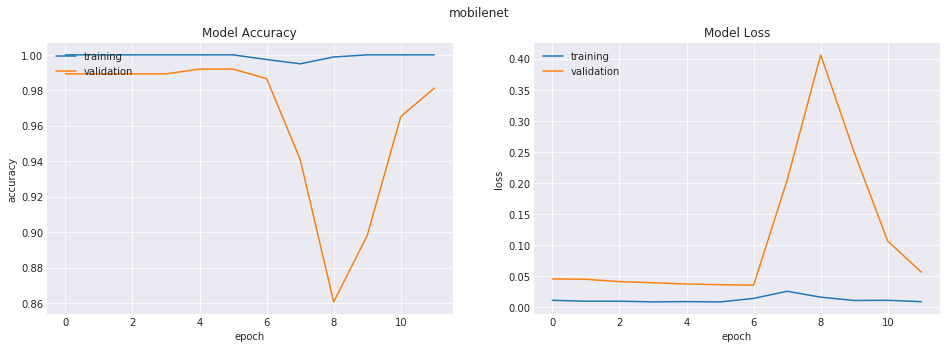

In [350]:
clf.learning_curves()

>These can also be visualized with Tensorboar:
```
tensorboard --logdir=./tensorboard_logs
```
The Tensorboard page can then be found on port `6006`  

We get the following results on the test set:

In [351]:
loss, acc = model.evaluate(data.X_test, data.y_test)

515/515 [==============================] - 1s 3ms/step


In [352]:
print("Loss     : {:.2%}\nAccuracy : {:.2%}".format(loss, acc))

Loss     : 12.78%
Accuracy : 94.76%


# 4. Results
---

Let's view the results for an exemple:

In [247]:
test_image_path = np.random.choice(glob("INRIAPerson/Test/*/*"))
test_image_path

'INRIAPerson/Test/pos/crop001661.png'

In [248]:
test_img = cv2.imread(test_image_path, 1)

## Predictions

We can choose to allow the classifier to make a descision on the class or to just show the probabilities:

In [251]:
with Time() as runtime:
    prediction = clf.predict(test_img, decision=False)

print("Prediction     :", prediction)
print('Execution time : {:.3f}ms'.format(1000*runtime()))

Prediction     : [0.0048041316, 0.9951958]
Execution time : 14.608ms


The model got the class right.

## Generating the Class Activation Maps

In [252]:
# Here we could import a previously saved model
# model = MobileNetGAP(path='saved_model/mobilenet.h5')
# clf = Classifier(model, name='mobilenet')

We can now view the regions that allowed the model to estimate the class probabilities:

Execution time : 45.591ms


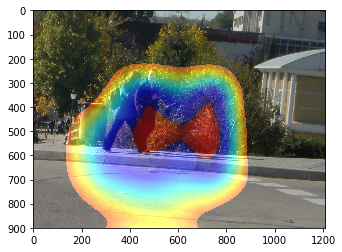

In [254]:
with Time() as runtime:
    cam, prediction = clf.cam(test_img, class_number=1)
    
plt.imshow(cam)
print('Execution time : {:.3f}ms'.format(1000*runtime()))

The CAM generation is quite fast 😎

Let's do that for a few other images:

In [44]:
def cam(clf):
    """
    cam for a random image
    """
    with Time() as runtime:
        test_image_path = np.random.choice(glob("INRIAPerson/Test/*/*"))
        test_img        = cv2.imread(test_image_path, 1)
        cam, prediction = clf.cam(test_img, class_number=1)
    
    print('Execution time : {:.3f}ms'.format(1000*runtime()))
    print("Prediction     :", data.classes[np.argmax(prediction)])
    plt.imshow(cam)

Execution time : 34.451ms
Prediction     : neg


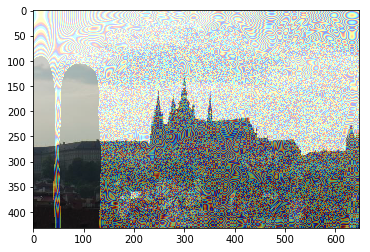

In [256]:
cam(clf)

Execution time : 42.599ms
Prediction     : neg


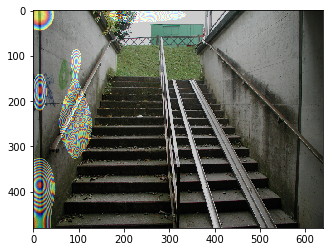

In [257]:
cam(clf)

Execution time : 48.638ms
Prediction     : pos


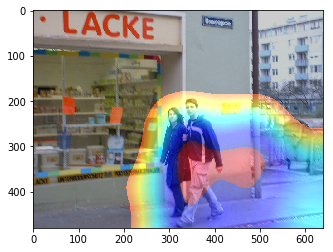

In [258]:
cam(clf)

# 5. Extending the dataset with images scraped from Google image

With the INRIA person dataset, the model overfits after a few iteration (~10). Moreover this dataset is limited and there are no close-up images for example. Therefore, the model doesn't perform well when presented with the image of a face. 

Let's add more images to this dataset.

In [14]:
from utilities import datasets

In [15]:
data_gi = datasets.GoogleImageScrapedDataset("googleImage")

In [50]:
# for keyword in ["room", "empty street", "animals", "forest", "house", "ghost town", "kitchen", "empty corridor"]:
#     data_gi.fillClass(class_name="neg", sample_size=100, keyword=keyword, valid=0.2, test=0.2)
    
# for keyword in ["woman", "man", "room with people", "person in street", "people in webcam", "girl", "boy", "dancer"]:
#     data_gi.fillClass(class_name="pos", sample_size=100, keyword=keyword, valid=0.2, test=0.2)

In [16]:
data_gi.load()

100%|██████████| 285/285 [00:03<00:00, 82.47it/s]


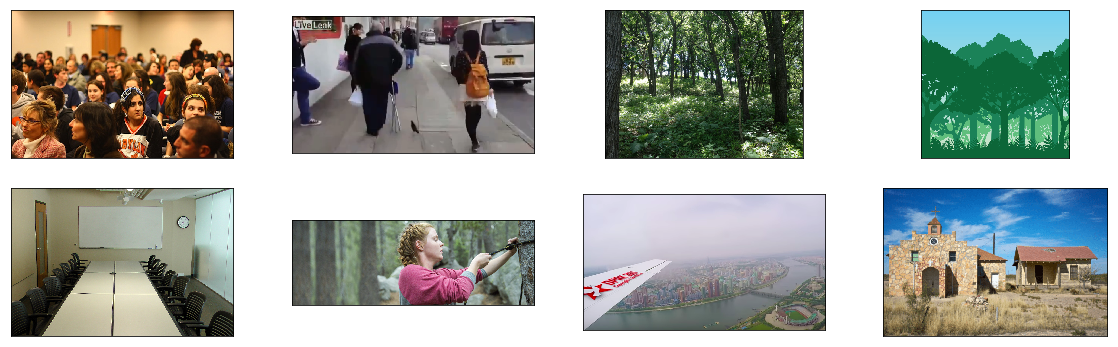

In [17]:
data_gi.examples(sample="Train", number=8)

In [18]:
data_gi.statistics()

,neg,pos,Total
Classes,,,
Train,416,414,830
Valid,147,138,285
Test,144,150,294
,707,702,1409


Let's now add to this new dataset, the images from the INRIA person dataset.

In [21]:
data_gi.merge(data)

In [22]:
data_gi.statistics()

,neg,pos,Total
Classes,,,
Train,827,837,1664
Valid,312,327,639
Test,355,438,793
,1494,1602,3096


### Training

In [ ]:
model_gi = MobileNetGAP(nb_classes=len(data.classes))

In [38]:
clf_gi = Classifier(model, name='mobilenet_with_gi_data')

clf_gi.fit(data_gi, epochs=100, batch_size=64, augmentation=True, verbose=1)

Instructions for updating:
Use the retry module or similar alternatives.
Epoch 1/100
25/25 [==============================] - 20s 785ms/step - loss: 0.7177 - acc: 0.8756 - val_loss: 1.1405 - val_acc: 0.7241
Epoch 2/100
25/25 [==============================] - 16s 646ms/step - loss: 0.4920 - acc: 0.9278 - val_loss: 0.5463 - val_acc: 0.9175
Epoch 3/100
25/25 [==============================] - 16s 658ms/step - loss: 0.3933 - acc: 0.9462 - val_loss: 0.3461 - val_acc: 0.9535
Epoch 4/100
25/25 [==============================] - 16s 659ms/step - loss: 0.2875 - acc: 0.9680 - val_loss: 0.2694 - val_acc: 0.9715
Epoch 5/100
25/25 [==============================] - 16s 650ms/step - loss: 0.2368 - acc: 0.9718 - val_loss: 0.2440 - val_acc: 0.9685
Epoch 6/100
25/25 [==============================] - 16s 644ms/step - loss: 0.1920 - acc: 0.9799 - val_loss: 0.2245 - val_acc: 0.9580
Epoch 7/100
25/25 [==============================] - 16s 642ms/step - loss: 0.1432 - acc: 0.9844 - val_loss: 0.1820 - val_a

### Evaluating

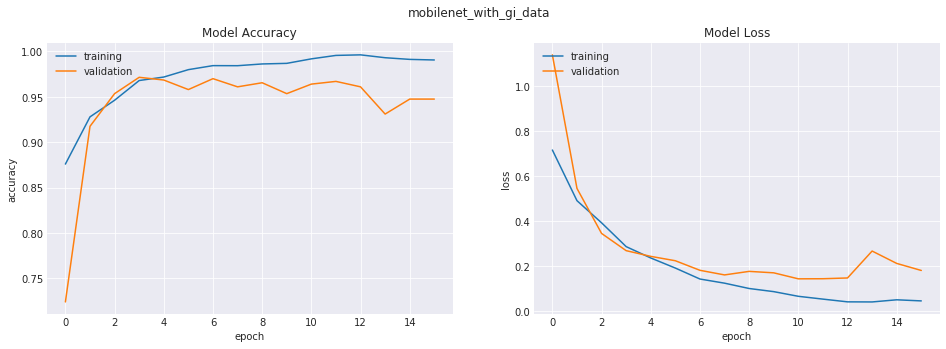

In [42]:
clf_gi.learning_curves()

In [ ]:
# Here we could import a previously saved model
# model_gi = MobileNetGAP(path='saved_model/mobilenet_with_gi_data.h5')
# clf = Classifier(model_gi, name='mobilenet_with_gi_data')

In [23]:
loss, acc = model_gi.evaluate(data.X_test, data.y_test)
print("Loss     : {:.2%}\nAccuracy : {:.2%}".format(loss, acc))

499/499 [==============================] - 2s 4ms/step
Loss     : 17.91%
Accuracy : 94.59%


In [65]:
def cam(clf):
    """
    cam for a random image
    """
    with Time() as runtime:
        test_image_path = np.random.choice(glob("googleImage/Test/*/*"))
        test_img        = cv2.imread(test_image_path, 1)
        cam, prediction = clf.cam(test_img, class_number=1)
    
    print('Execution time : {:.3f}ms'.format(1000*runtime()))
    print("Prediction     :", data.classes[np.argmax(prediction)])
    plt.imshow(cam)

Execution time : 31.887ms
Prediction     : pos


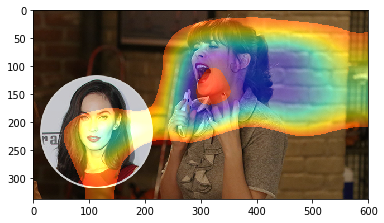

In [88]:
cam(clf)

Execution time : 39.127ms
Prediction     : pos


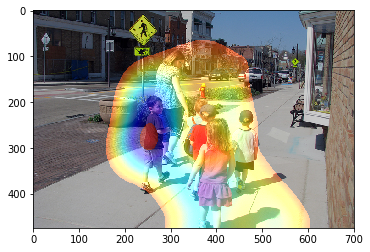

In [90]:
cam(clf)

Execution time : 39.055ms
Prediction     : pos


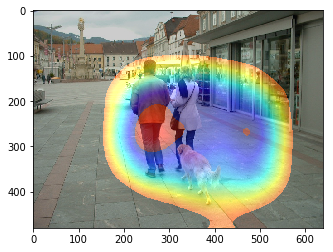

In [71]:
cam(clf)

Execution time : 32.655ms
Prediction     : neg


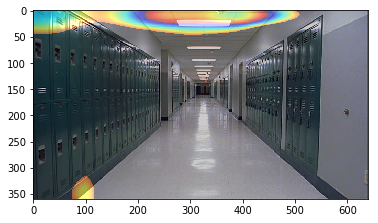

In [106]:
cam(clf)

Execution time : 40.088ms
Prediction     : neg


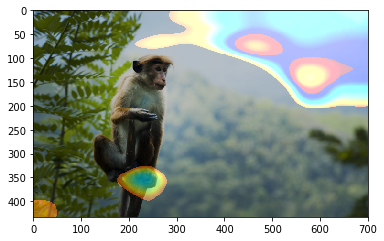

In [73]:
cam(clf)

# Google Open Image dataset - WIP

*Work In Progress*

In [107]:
import pandas as pd

In [299]:
complete_dataframe = pd.read_csv("2017_11/train/annotations-human.csv")

In [285]:
with open("2017_11/classes-bbox.txt", 'r') as classes_file:
    classes = classes_file.read().splitlines()

In [300]:
dataframe = complete_dataframe.head(100000)

In [214]:
# dataframe1 = dataframe.copy(deep=True)

In [301]:
dataframe.dtypes

ImageID        object
LabelName    category
dtype: object

In [14]:
# Droping the 'Source' column
dataframe = dataframe.drop(['Source'], axis=1)

# Selecting only the rows encoding a label that has been recognized
dataframe = dataframe[(dataframe.Confidence == 1)]

# Selecting only the rows encoding a label that is part of the 601 classes-bbox
dataframe = dataframe[dataframe.LabelName.isin(classes)]

# Droping the 'Confidence' column
dataframe = dataframe.drop(['Confidence'], axis=1)

dataframe['LabelName'] = dataframe['LabelName'].astype('category')

dataframe.head()

from collections import defaultdict

ImageIDs = dict((ImageID,np.zeros(len(classes))) for ImageID in list(dataframe['ImageID'].unique()))

classes_dict = dict((classe, index) for index, classe in enumerate(classes))

len(ImageIDs)

(len(ImageIDs), len(classes))

with Time() as t:
    for _, row in dataframe.iterrows():
        ImageID   = row['ImageID']
        LabelName = row['LabelName']
        ImageIDs[ImageID][classes_dict[LabelName]] = 1

NameError: name 'dataframe' is not defined

In [322]:
ImageIDs["000002b66c9c498e"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0.

In [334]:
image_ids = ImageIDs.keys()
y_train = list(ImageIDs.values())

---





In [1]:
classes_file_path = "2017_11/classes-bbox.txt"

with open(classes_file_path, 'r') as classes_file:
    classes = classes_file.read().splitlines()
    
# keys = class encoding, values = index in 0...600
classes_dict = dict((classe, index) for index, classe in enumerate(classes))

In [2]:
import pandas as pd
import numpy  as np

In [ ]:
# all the classes
classes_file_path = "2017_11/classes-bbox.txt"

with open(classes_file_path, 'r') as classes_file:
    classes = classes_file.read().splitlines()

In [10]:
def load_targets(annotation_csv_path, classes):
    """
    load only human and non human targets
    """
    # keys = class encoding, values = index in 0...600
    classes_dict = dict((classe, index) for index, classe in enumerate(classes))
    
    dataframe = pd.read_csv(annotation_csv_path).head(10000)
    
    # Droping the 'Source' column
    dataframe = dataframe.drop(['Source'], axis=1)

    # Selecting only the rows encoding a label that has been recognized and that is part of the 601 classes-bbox
    dataframe = dataframe[(dataframe.Confidence == 1) & (dataframe.LabelName.isin(classes))]

    # Droping the 'Confidence' column
    dataframe = dataframe.drop(['Confidence'], axis=1)
    
    # keys = image id, values = classes 
    targets = dict((ImageID,np.zeros(len(classes))) for ImageID in list(dataframe['ImageID'].unique()))

    for _, row in dataframe.iterrows():
        ImageID   = row['ImageID']
        LabelName = row['LabelName']
        targets[ImageID][classes_dict[LabelName]] = 1
        
    return targets

In [11]:
classes_human_or_not = ['/m/0dgw9r', "neg"]

In [12]:
annotation_csv_path = "2017_11/train/annotations-human.csv"

targets = load_targets("2017_11/train/annotations-human.csv", classes_human_or_not)

In [13]:
targets

{'000002c707c9895e': array([1., 0.]),
 '000004f4400f6ec5': array([1., 0.]),
 '0000071d71a0a6f6': array([1., 0.]),
 '000025ea48cab6fc': array([1., 0.]),
 '0000271195f2c007': array([1., 0.]),
 '0000313e5dccf13b': array([1., 0.]),
 '000033469fb48bc1': array([1., 0.]),
 '0000339d0372e7e6': array([1., 0.]),
 '00004b19ca2c952f': array([1., 0.])}